In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import random
import numpy as np
import os
import argparse

SEED = 1000
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

from dataloader import DataLoader

NUM_CONV_LAYERS = 4
SAVE_INTERVAL = 100
LOG_INTERVAL = 1
VAL_INTERVAL = 50
NUM_TRAIN_TASKS = 20
NUM_TEST_TASKS = 100
NUM_ITERATIONS = 1500

2022-05-18 22:48:23.847718: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
num_classes, n_support, n_query = 5, 5, 15
num_inner_steps = 5
_outer_lr = 0.001
_inner_lr = 0.4

In [3]:
train_data = DataLoader('train', num_classes, n_support, n_query)
val_data = DataLoader('test', num_classes, n_support, n_query)

2022-05-18 22:48:30.787960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 22:48:30.793479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 22:48:30.800807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 22:48:30.801738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

	-Preprocessing train Omniglot dataset
	-Preprocessing test Omniglot dataset


In [4]:
model_layers = [layers.Input(shape=(28,28,1))]

for i in range(NUM_CONV_LAYERS):
    model_layers.append(
        layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", name=f"Conv{i+1}")
    )
    model_layers.append(
        layers.BatchNormalization(name=f"BN{i+1}")
    )
    model_layers.append(
        layers.ReLU(name=f"ReLU{i+1}")
    )
model_layers.append(layers.Flatten())
model_layers.append(layers.Dense(num_classes, activation='softmax', name='Classification'))
model = keras.Sequential(model_layers)

In [5]:
val_batches = val_data.generate_task(NUM_TEST_TASKS)

In [6]:
train_task = train_data.generate_task(NUM_TRAIN_TASKS)

## Outer 0

In [7]:
_optimizer = keras.optimizers.Adam(learning_rate=_outer_lr)

theta = tf.nest.map_structure(lambda x: tf.Variable(tf.zeros_like(x)), model.trainable_weights)
tf.nest.map_structure(lambda x, y: x.assign(y), theta, model.trainable_weights)

task_batch = train_task
for task in task_batch:
    support, query = task
    break

tf.Tensor([1 2 0 4 1 3 0 0 4 3 3 3 2 1 0 4 4 4 3 0 2 1 2 1 2], shape=(25,), dtype=int8)
tf.Tensor([0 2 3 0 4 4 4 2 0 2 3 4 0 2 3 3 1 4 0 1 1 2 3 1 1], shape=(25,), dtype=int8)
tf.Tensor([2 3 3 2 4 2 2 3 1 4 4 0 1 1 2 0 0 4 3 3 0 0 1 4 1], shape=(25,), dtype=int8)
tf.Tensor([1 2 0 1 3 4 2 0 2 0 4 2 4 0 0 3 4 4 1 3 1 3 3 2 1], shape=(25,), dtype=int8)
tf.Tensor([4 1 1 3 4 1 2 0 2 2 4 3 2 3 1 3 0 0 4 2 0 4 3 0 1], shape=(25,), dtype=int8)


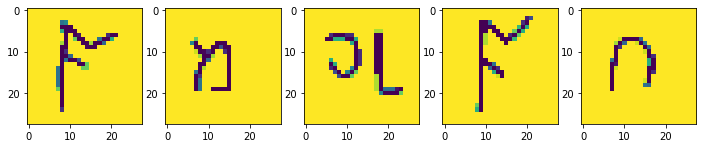

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(12, 10))
for i in range(5):
    imgs, label = support.take(1).get_single_element()
    axes[i].imshow(imgs[0].numpy().squeeze())
    print(label)

## Inner

In [9]:
def inner_run(theta, support_data):
    accuracies = []
    
    phi = tf.nest.map_structure(lambda x: tf.Variable(tf.zeros_like(x)), model.trainable_weights)
    tf.nest.map_structure(lambda x, y: x.assign(y), phi, theta)

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    opt_fn = tf.keras.optimizers.SGD(learning_rate=_inner_lr)
    metrics_fn = tf.keras.metrics.SparseCategoricalAccuracy(name='Inner Accuracy')
    for imgs, label in support_data:
        for _ in range(num_inner_steps):
            with tf.GradientTape() as tape:
                logits = model(imgs, training=True)
                loss = loss_fn(label, logits)
            grads = tape.gradient(loss, model.trainable_weights)
            opt_fn.apply_gradients(zip(grads, phi))
            opt_fn.apply_gradients(zip(grads, model.trainable_weights))
            metrics_fn.update_state(label, logits)
            accuracies.append(metrics_fn.result().numpy())
    return phi, accuracies

In [10]:
phi, accuracies = inner_run(theta, support_data=support)

2022-05-18 22:48:52.072402: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


In [11]:
accuracies

[0.12, 0.24, 0.41333333, 0.44, 0.48]

## Outer 1

In [12]:
train = True

In [13]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
metrics_fn = tf.keras.metrics.SparseCategoricalAccuracy(name='Outer Accuracy')

outer_loss_batch = []
accuracies_support_batch = []
accuracy_query_batch = []

In [22]:
# in the batch loop
all_grads = tf.nest.map_structure(lambda x: tf.Variable(tf.zeros_like(x)), model.trainable_weights)
outer_loss = 0
metrics_fn.reset_states()
for imgs, label in query:
    with tf.GradientTape() as tape:
        logits = model(imgs, training=train)
        loss = loss_fn(label, logits)
    grads = tape.gradient(loss, model.trainable_weights)
    all_grads = tf.nest.map_structure(lambda x, y: x + y, all_grads, grads)
    outer_loss += loss
    metrics_fn.update_state(label, logits)
    
_optimizer.apply_gradients(zip(all_grads, theta))

accuracies_support_batch.append(accuracies)
accuracy_query_batch.append(metrics_fn.result().numpy())
outer_loss_batch.append(outer_loss)


In [ ]:
grads = tape.gradient(loss, phi)

In [23]:
theta

[<tf.Variable 'Variable:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
 array([[[[ 0.03257104,  0.0392295 ,  0.09839436, -0.00682068,
           -0.01256056, -0.06069282,  0.03444473, -0.08567508,
            0.03780126,  0.05607734, -0.09270489,  0.09913502,
           -0.09661894,  0.09742324,  0.02851888,  0.05849676,
           -0.08358254, -0.02608615, -0.04704965,  0.01985909,
           -0.02265133,  0.04012399, -0.10038631,  0.06710951,
           -0.06756967, -0.01970972, -0.07207561, -0.0590258 ,
           -0.08006756, -0.02435984, -0.05934443, -0.04882511,
           -0.02438479, -0.05517994, -0.09194963, -0.10080533,
           -0.05695156,  0.04660436,  0.06131041, -0.06375719,
            0.06392576,  0.01586633,  0.06596548,  0.02798546,
           -0.01155591, -0.05405794,  0.00248925,  0.08257835,
           -0.01250957,  0.05475715,  0.05736688,  0.06220774,
           -0.05156367,  0.09055678, -0.04476368, -0.05775344,
           -0.05278301, -0.07446383,  0.08442669,

In [109]:
with tf.GradientTape() as tape:
    logits = model(imgs, training=True)
    loss = loss_fn(label, logits)
grads = tape.gradient(loss, model.trainable_weights)
opt_fn.apply_gradients(zip(grads, phi))
metrics_fn.update_state(label, logits)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=25.0>

In [111]:
print(metrics_fn.result())

tf.Tensor(0.12, shape=(), dtype=float32)
